# 1. Dataset with daily number of posts on medium.com website


## Load the data

In [1]:
from common import *

df = pd.read_csv('medium_posts.csv')
df['published_date'] = pd.to_datetime(df['published']).dt.date
df = df.drop(columns='published')

df_by_day = df['published_date'].value_counts().sort_index() # sum articles for each year
df_by_day = df_by_day.to_frame().reset_index()
df_by_day.rename(columns={"published_date": "y", "index": "ds"}, inplace=True) # rename columns using Prophet's convention
df_by_day

,ds,y
0,1970-01-01,2
1,1970-01-18,3
2,2003-09-14,1
3,2004-04-04,1
4,2004-04-16,1
...,...,...
1733,2017-06-23,421
1734,2017-06-24,277
1735,2017-06-25,253
1736,2017-06-26,207


Two rows are from 1970 - it's probably an error. Let's remove them and plot the data:

Text(0, 0.5, 'Number of posts')

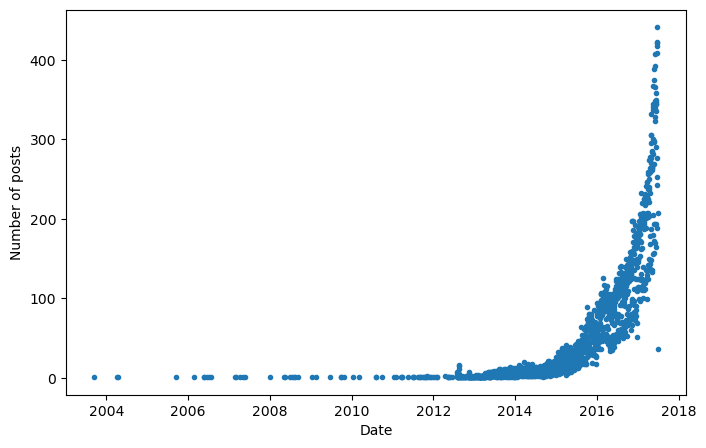

In [2]:
df_by_day = df_by_day.iloc[2:]
plt.figure(figsize=(8,5))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts")

Until 2013 there are a lot of dates without number of posts. In these years Medium was probably very small website and using that thata can lead to unreliable predictions. I'll cut all rows to 01-01-2013.

Text(0, 0.5, 'Number of posts')

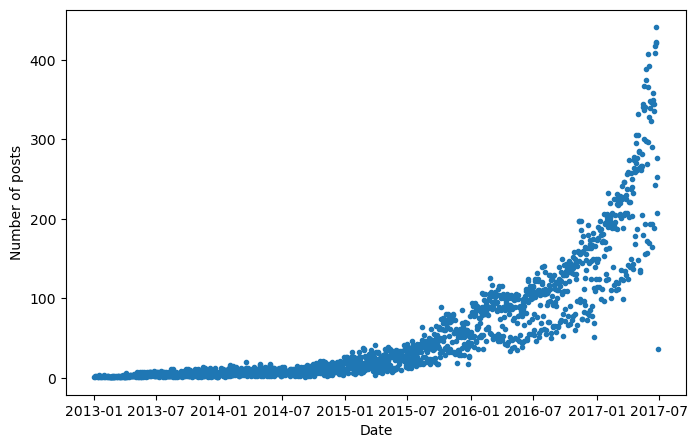

In [3]:
cut_date = datetime.date(2013, 1, 1)
df_by_day = df_by_day[df_by_day.ds > cut_date]
plt.figure(figsize=(8,5))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts")

# Prediction for standard parameters, forecast components:

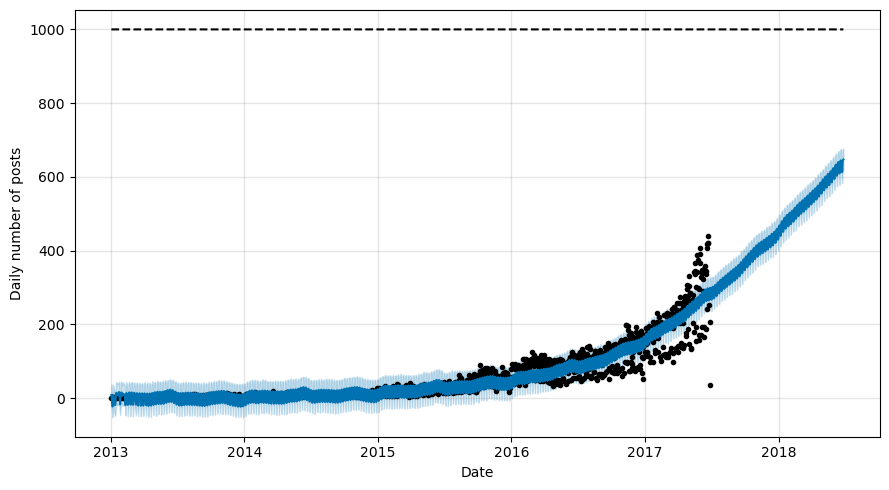

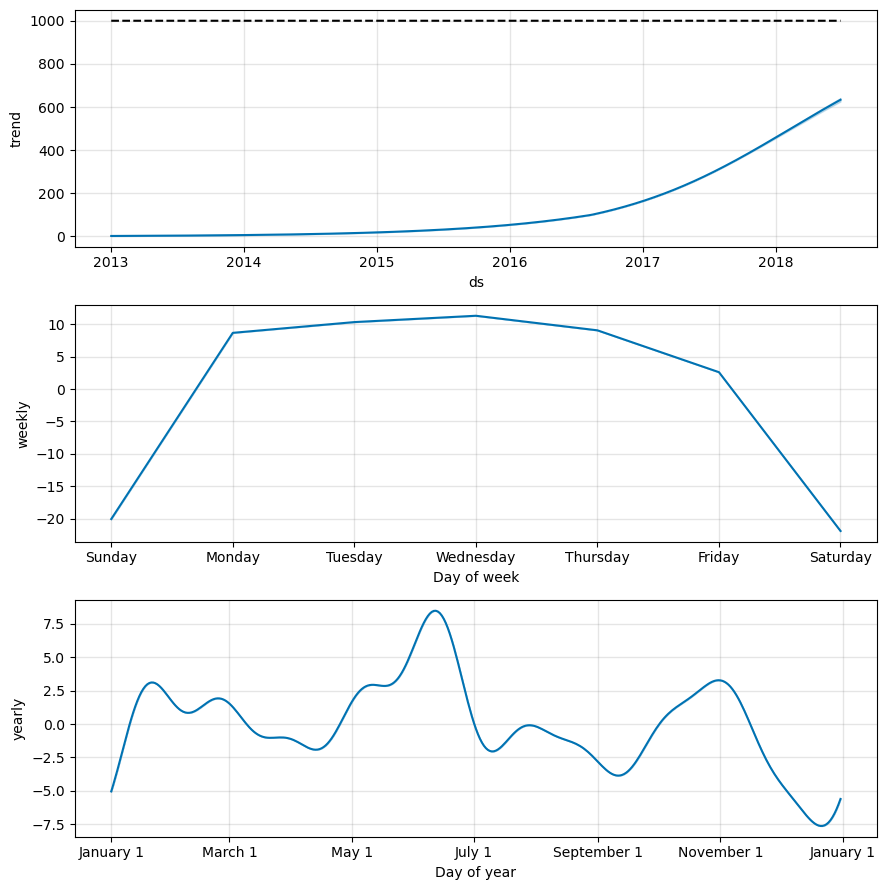

In [5]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
m = Prophet(growth='logistic')
df_by_day['cap'] = 1000
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(9, 5), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast)

# Cross validation, metrics

  0%|          | 0/3 [00:00<?, ?it/s]

Mean MAE: 25.719122798589403
Mean MAPE: 29.287699249711096 %


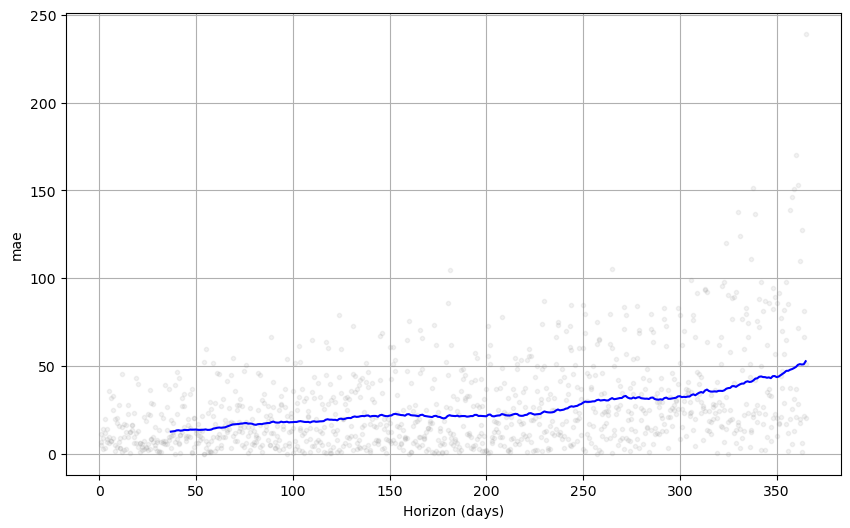

In [6]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
print("Mean MAPE:", str(df_p['mape'].mean() * 100), '%')
fig = plot_cross_validation_metric(df_cv, metric='mae')

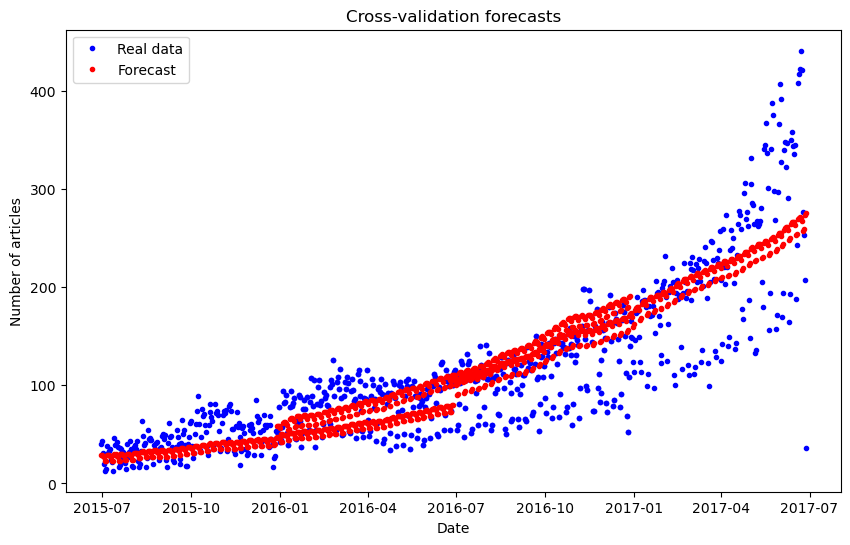

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')

plt.show()

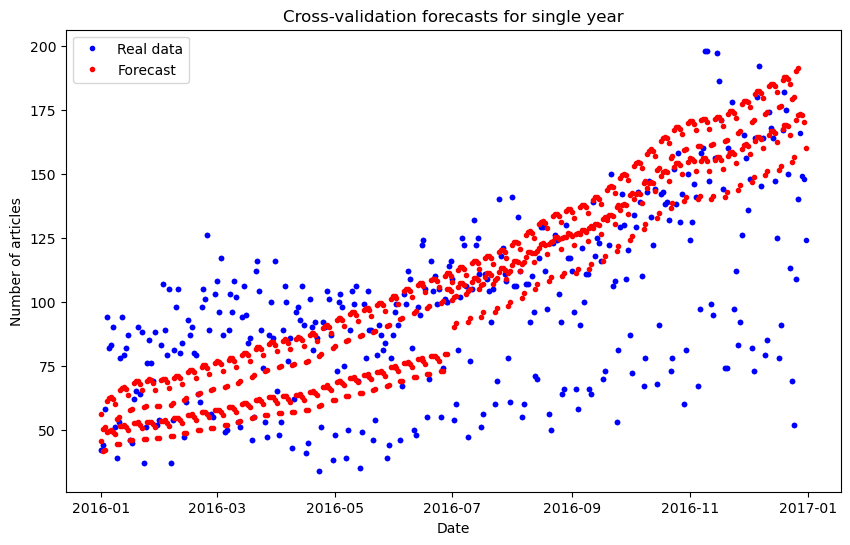

In [8]:
lower_date = np.datetime64('2016-01-01')
upper_date = np.datetime64('2017-01-01')
year_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(year_forecast['ds'], year_forecast['y'], 'b.', label='Real data')
ax.plot(year_forecast['ds'], year_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts for single year')

plt.show()

# Hyperparameters tuning

In [8]:
import warnings
warnings.filterwarnings("ignore")

tune_optuna_logistic(df_by_day, 1000, save_study_name="medium-study-logistic-mape-shorter-cut", metric='mape')

[I 2023-03-12 12:08:40,182] A new study created in RDB with name: medium-study-logistic-mape-shorter-cut


Best trial:
   mape :  0.16693401279454115
  Params: 
    changepoint_prior_scale: 0.3758001747787103
    changepoint_range: 0.9318725689779309
    holidays_prior_scale: 0.017984952317648
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.029518181474767858


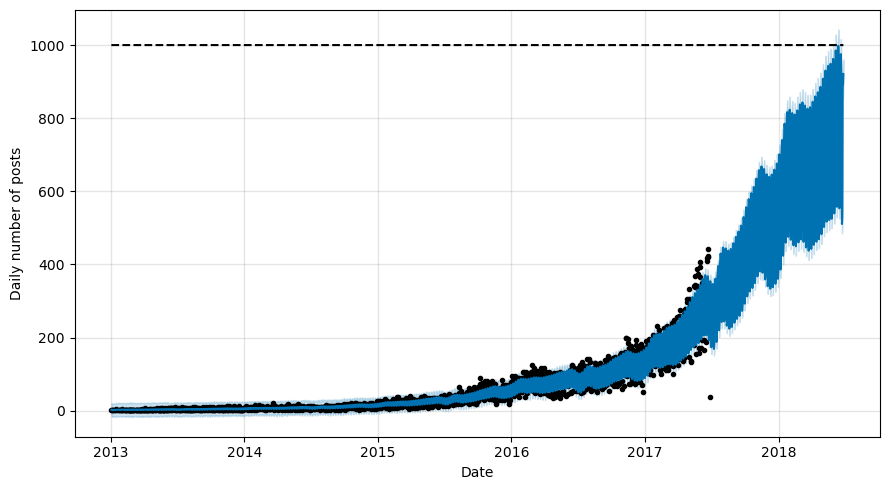

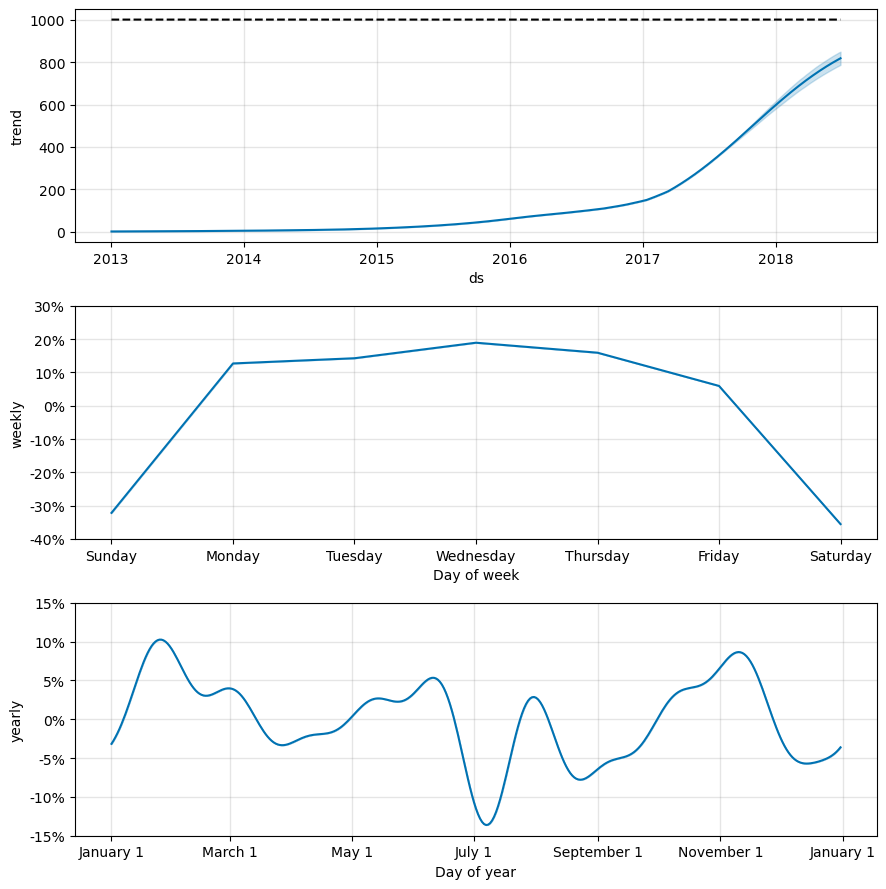

In [31]:
m = Prophet(changepoint_prior_scale=0.3758001747787103, changepoint_range=0.9318725689779309,
           holidays_prior_scale=0.017984952317648, seasonality_mode='multiplicative',
           seasonality_prior_scale=0.029518181474767858, growth='logistic')
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(9, 5), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast)

  0%|          | 0/3 [00:00<?, ?it/s]

Mean MAE: 18.458596128416353
Mean MAPE: 15.99771517901695 %


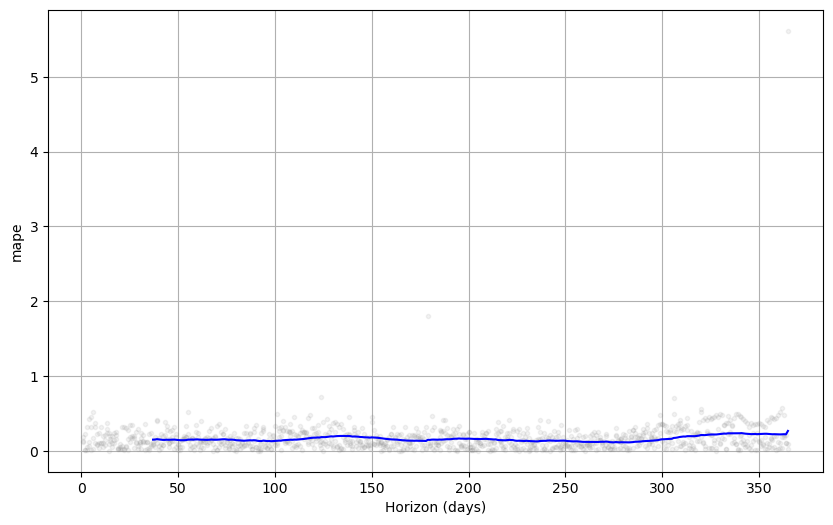

In [14]:
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
print("Mean MAPE:", str(df_p['mape'].mean()*100), '%')
fig = plot_cross_validation_metric(df_cv, metric='mape')

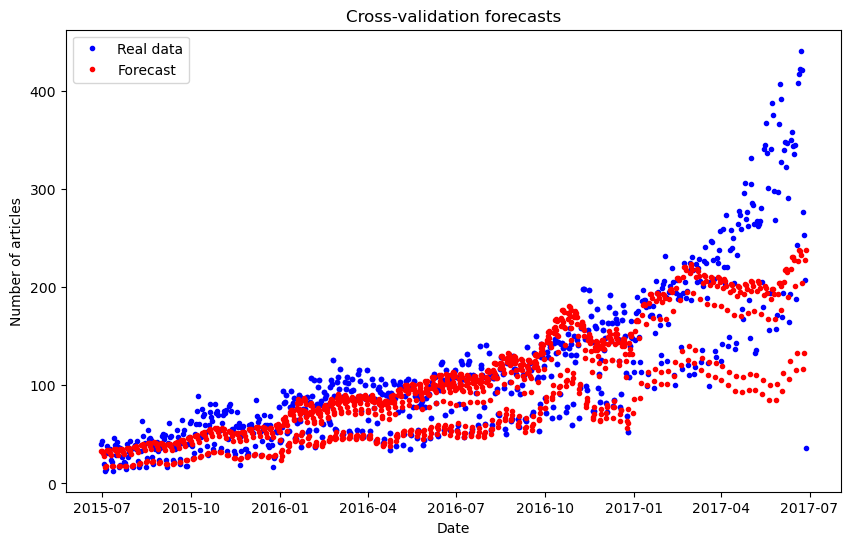

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

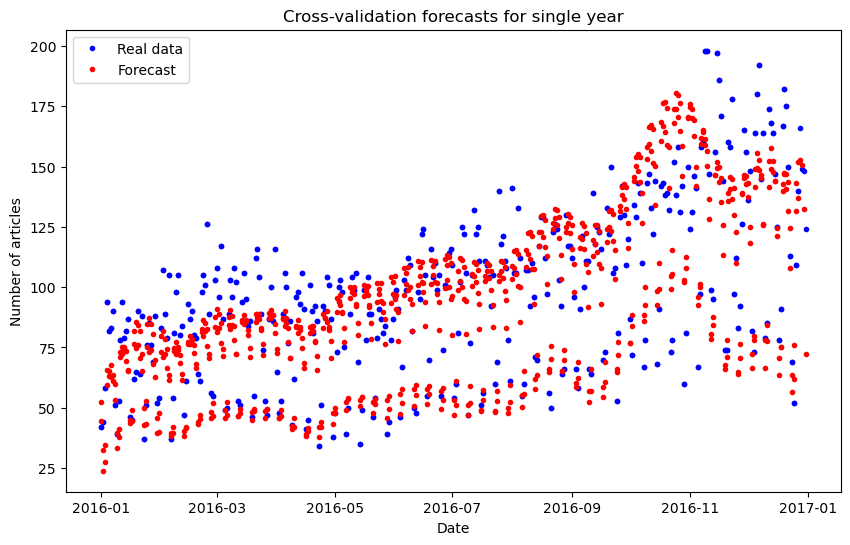

In [34]:
lower_date = np.datetime64('2016-01-01')
upper_date = np.datetime64('2017-01-01')
year_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(year_forecast['ds'], year_forecast['y'], 'b.', label='Real data')
ax.plot(year_forecast['ds'], year_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.set_title('Cross-validation forecasts for single year')
ax.legend(loc='upper left')

plt.show()

# 2. Dataset with hourly number of ads

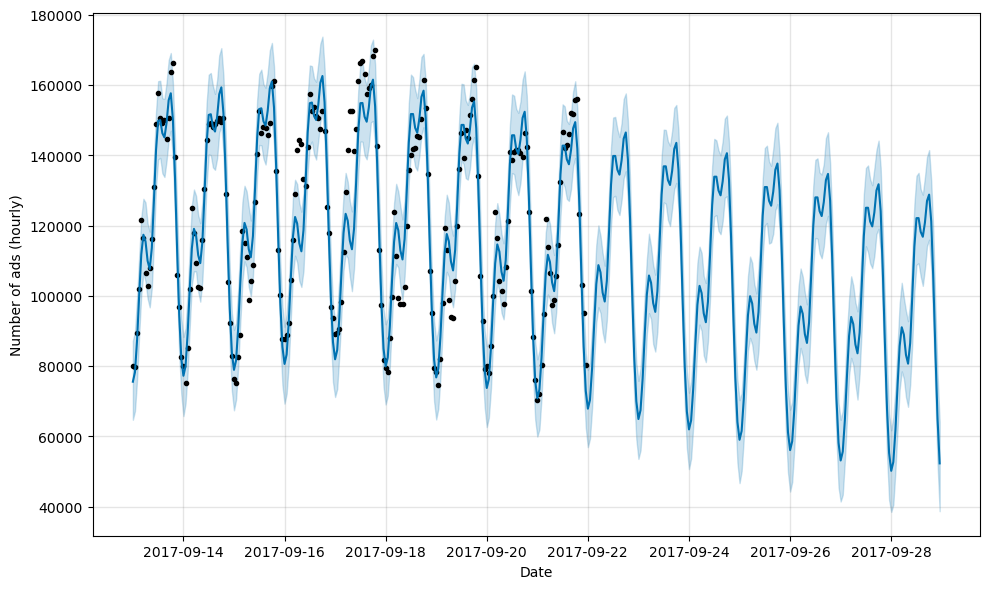

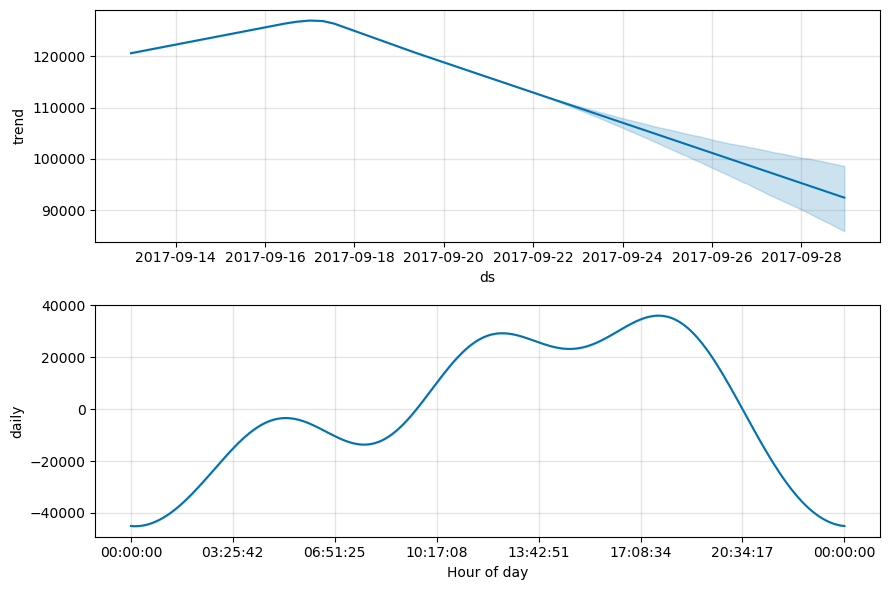

In [9]:
df = pd.read_csv('ads.csv')
df.rename(columns={"Time":"ds", "Ads":"y"}, inplace=True)

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=24*7, freq='H')
forecast = m.predict(future)

fig1 = m.plot(forecast, xlabel="Date", ylabel="Number of ads (hourly)")
fig2 = m.plot_components(forecast)

Mean MAPE:  0.06944672897219573


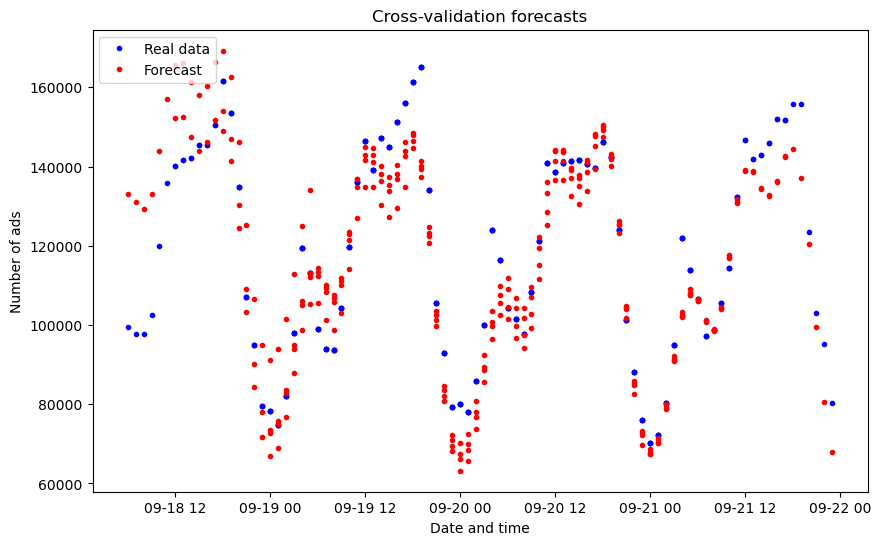

In [10]:
df_cv = cross_validation(m, initial='5 days', period='6 hours', horizon = '24 hours', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAPE: ", str(df_p['mape'].mean()))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date and time')
ax.set_ylabel('Number of ads')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

In [12]:
tune_optuna(df, save_study_name='ads', metric="mape", initial='5 days', period='6 hours', horizon='24 hours')

/home/jsowa/work/prophet/common.py:83: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


Best trial:
   mape :  0.06087658873860407
  Params: 
    changepoint_prior_scale: 0.035033218143421044
    changepoint_range: 0.8548855487747484
    holidays_prior_scale: 4.158901360548356
    seasonality_mode: additive
    seasonality_prior_scale: 0.029310502345129764


# 3. Bike sharing demand dataset

In [2]:
from common import *

df = pd.read_csv('bike_demand.csv')
df.rename(columns={"datetime":"ds", "count":"y"}, inplace=True)
df.head()

,ds,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,y
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


16:38:45 - cmdstanpy - INFO - Chain [1] start processing
16:38:53 - cmdstanpy - INFO - Chain [1] done processing


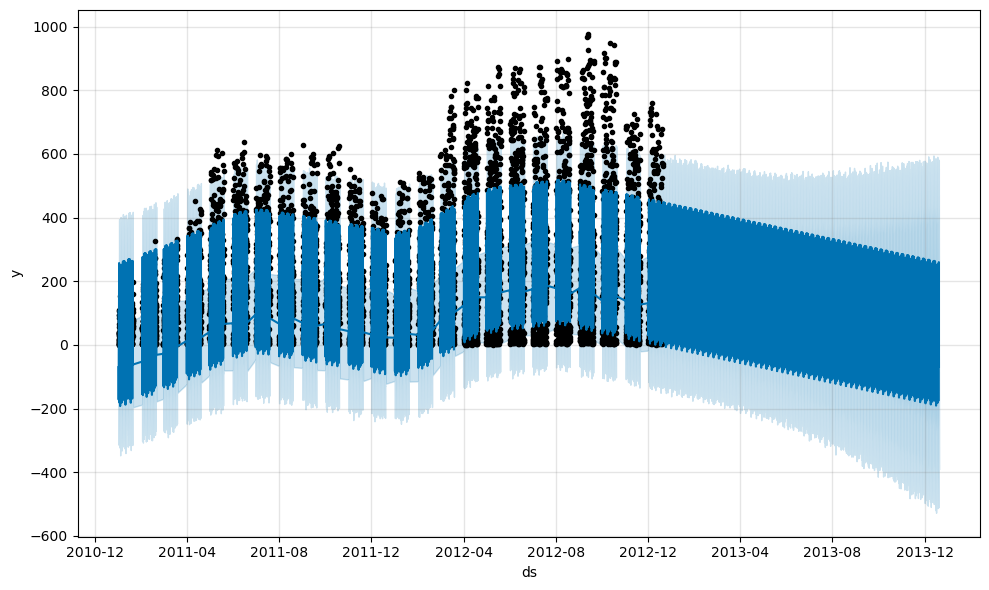

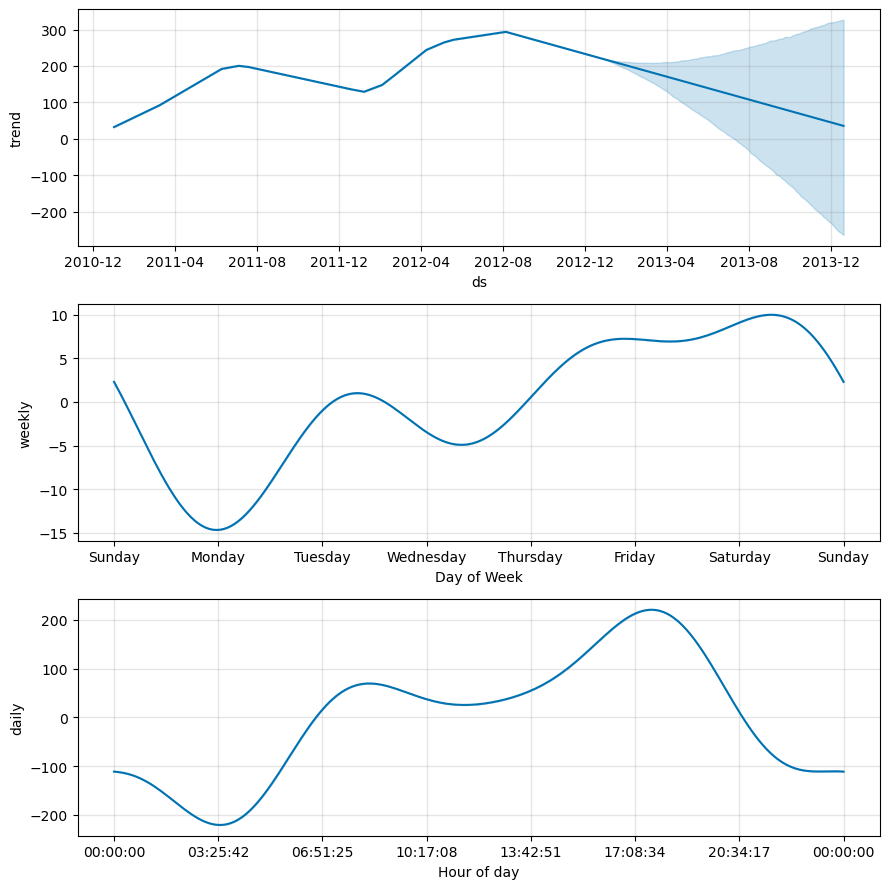

In [3]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

What's wrong with this forecast? By default Prophet look for yearly seasonality only if there are two full years of data. This kind of information is very important in this model. For example - people ride a bike in winter less often than in summer. Let's try to add it manually:

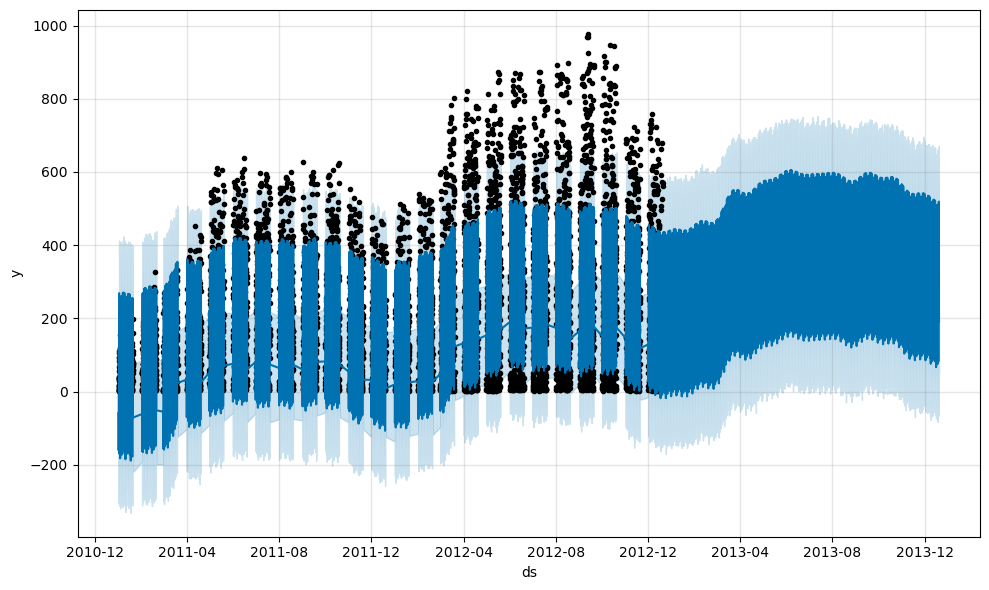

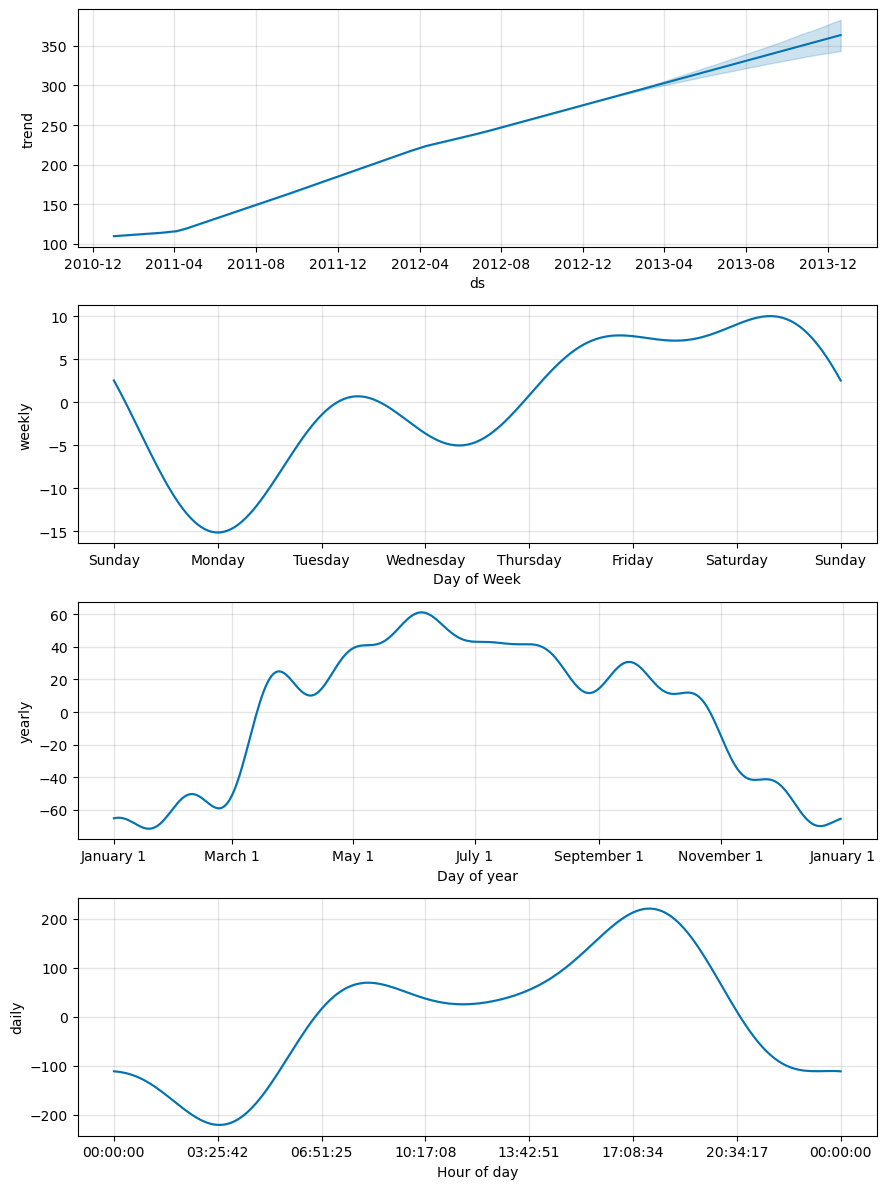

In [15]:
m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.fit(df)
future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

Now the trend looks completely different and forecast for next year is more reliable.

Mean MAE:  102.04763012417447


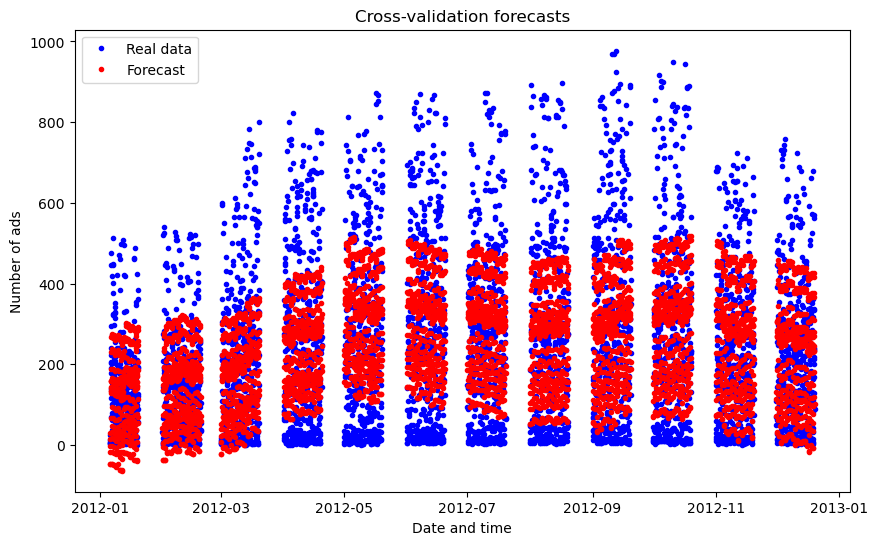

In [16]:
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date and time')
ax.set_ylabel('Number of ads')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

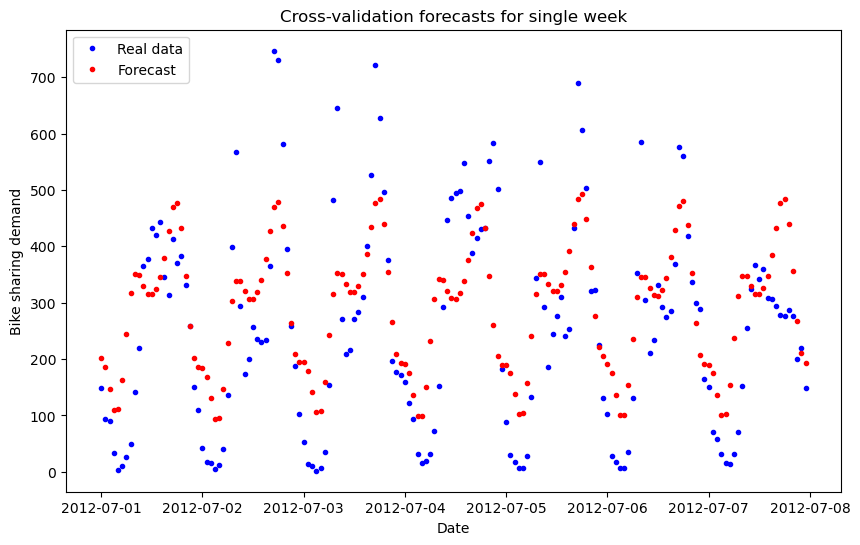

In [17]:
lower_date = np.datetime64('2012-07-01')
upper_date = np.datetime64('2012-07-08')
week_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(week_forecast['ds'], week_forecast['y'], 'b.', label='Real data')
ax.plot(week_forecast['ds'], week_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Bike sharing demand')
ax.set_title('Cross-validation forecasts for single week')
ax.legend(loc='upper left')

plt.show()

## Add regressors:

In [20]:
start_time = time.time()
m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.fit(df)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE score without additional regressors: ", str(df_p['mae'].mean()))
print("Calculations time without additional regressors: %s seconds" % (time.time() - start_time))

start_time = time.time()
m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.add_regressor('weather')
m.add_regressor('temp')
m.add_regressor('humidity')
m.add_regressor('windspeed')
m.add_regressor('holiday')
m.add_regressor('workingday')
m.add_regressor('season')
m.fit(df)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE score with additional regressors: ", str(df_p['mae'].mean()))
print("Calculations time with additional regressors: %s seconds" % (time.time() - start_time))

Mean MAE score without additional regressors:  102.04763012417447
Calculations time without additional regressors: 13.605329990386963 seconds
Mean MAE score with additional regressors:  98.34879310529793
Calculations time with additional regressors: 15.252129554748535 seconds


# Tuning:

In [21]:
tune_optuna(df, save_study_name="bike_demand_hourly", regressors=['weather', 'temp', 'humidity', 'windspeed', 'holiday', 'workingday', 'season'],
           initial="365 days", period="7 days", horizon="7 days", manual_yearly_seasonality=True)

[I 2023-03-13 17:28:37,708] Using an existing study with name 'bike_demand_hourly' instead of creating a new one.
/home/jsowa/work/prophet/common.py:92: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


Best trial:
   mae :  89.04238518679264
  Params: 
    changepoint_prior_scale: 0.11240572391950829
    changepoint_range: 0.9456278189168777
    holidays_prior_scale: 79.36381162503282
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.13410561338989938


Mean MAE:  89.65655071079948
--- 52.40064764022827 seconds ---


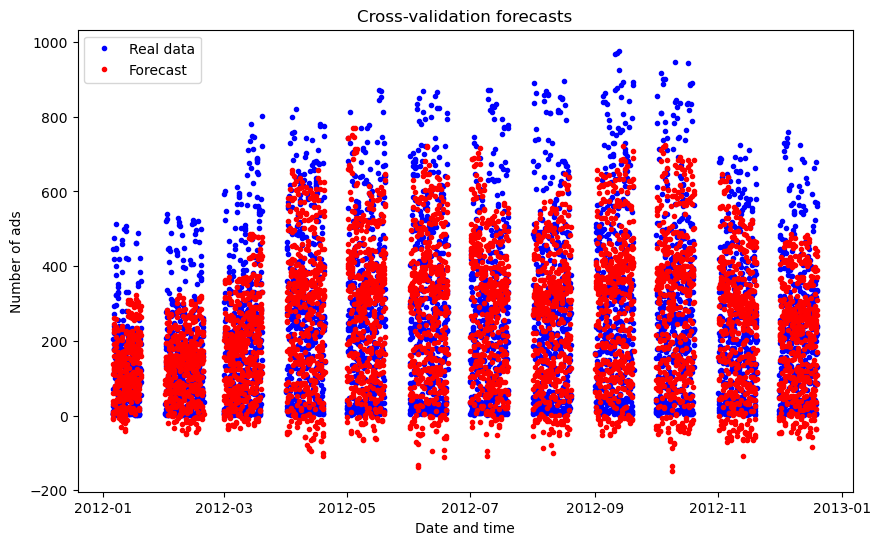

In [24]:
start_time = time.time()

m = Prophet(changepoint_prior_scale=0.11240572391950829, changepoint_range=0.9456278189168777,
           holidays_prior_scale=79.36381162503282, seasonality_mode='multiplicative',
           seasonality_prior_scale=0.13410561338989938)
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.add_regressor('weather')
m.add_regressor('temp')
m.add_regressor('humidity')
m.add_regressor('windspeed')
m.add_regressor('holiday')
m.add_regressor('workingday')
m.add_regressor('season')
m.fit(df)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))
print("--- %s seconds ---" % (time.time() - start_time))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date and time')
ax.set_ylabel('Number of ads')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

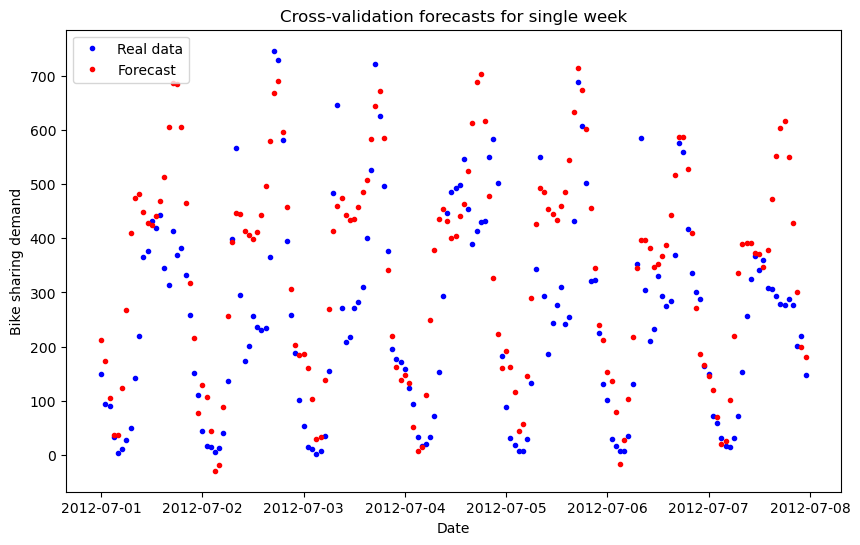

In [25]:
lower_date = np.datetime64('2012-07-01')
upper_date = np.datetime64('2012-07-08')
week_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(week_forecast['ds'], week_forecast['y'], 'b.', label='Real data')
ax.plot(week_forecast['ds'], week_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Bike sharing demand')
ax.set_title('Cross-validation forecasts for single week')
ax.legend(loc='upper left')

plt.show()

## Add floor:

Mean MAE:  87.4864663558957
--- 51.4992790222168 seconds ---


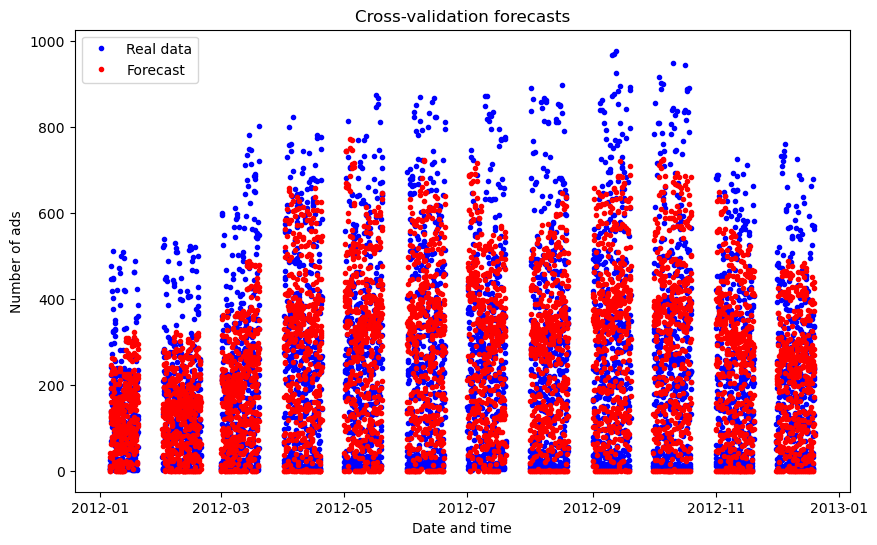

In [38]:
start_time = time.time()

m = Prophet(changepoint_prior_scale=0.11240572391950829, changepoint_range=0.9456278189168777,
           holidays_prior_scale=79.36381162503282, seasonality_mode='multiplicative',
           seasonality_prior_scale=0.13410561338989938)
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.add_regressor('weather')
m.add_regressor('temp')
m.add_regressor('humidity')
m.add_regressor('windspeed')
m.add_regressor('holiday')
m.add_regressor('workingday')
m.add_regressor('season')
m.fit(df)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_cv.loc[df_cv.yhat<0, 'yhat'] = 0
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))
print("--- %s seconds ---" % (time.time() - start_time))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date and time')
ax.set_ylabel('Number of ads')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

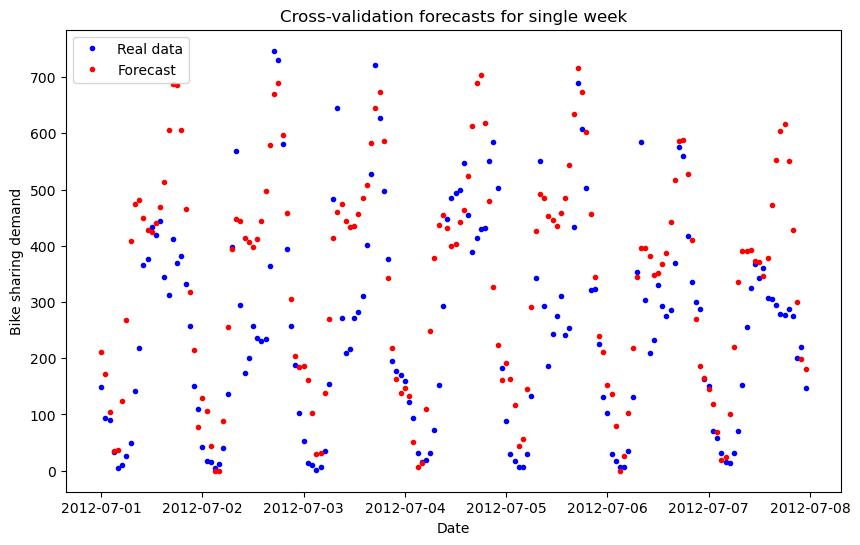

In [39]:
lower_date = np.datetime64('2012-07-01')
upper_date = np.datetime64('2012-07-08')
week_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(week_forecast['ds'], week_forecast['y'], 'b.', label='Real data')
ax.plot(week_forecast['ds'], week_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Bike sharing demand')
ax.set_title('Cross-validation forecasts for single week')
ax.legend(loc='upper left')

plt.show()